# **Shot type classification: VGG16 + SVM**

### In this notebook, a classification task of the different types of cinematographic shots has been implemented. The implemented approach exploits the VGG16 neural network to extract the relevant information from each image(featurization), i.e. the features, while an SVM model has the task of classifying these images among the 5 classes present:


*   ### Close-up
*   ### Medium close-up
*   ### Medium shot
*   ### Medium wide
*   ### Wide shot





# **0. Spark + Google Colab Setup**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/drive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "<path>"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "<path>"
GDRIVE_DATA_CSV = GDRIVE_HOME_DIR + "<path>"

RANDOM_SEED = 42 # for reproducibility

# Point Colaboratory to our Google Drive
from google.colab import drive
drive.mount(GDRIVE_DIR, force_remount=True)

import os
os.environ["JAVA_HOME"] = JAVA_HOME

Mounted at /content/drive


## **0.1.** Install PySpark and related dependencies

In [ ]:
!pip install pyspark
!apt install openjdk-8-jdk-headless -qq

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.serializers import PickleSerializer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=b8b354d7e01572fb15339257550172b75b3e59eb10008ab62b5d5a4922438bcc
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:a

## **0.2.** Create Spark context

In [ ]:
# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("shot_type_SVM").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

# **1. Useful imports**

In [ ]:
import PIL.Image as Image
from PIL import ImageFilter
import io

import numpy as np
import matplotlib.pyplot as plt
import cv2
from os import listdir
import pandas as pd
import imutils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input

from pyspark.sql.functions import col, udf, pandas_udf, PandasUDFType
from pyspark.sql.types import StringType
from pyspark.ml.linalg import VectorUDT, Vectors

# **2. Shot type classification**

## **2.1** Loading the shot type dataset and creating the train and test sets

### Read shot type dataset into a spark dataframe

In [ ]:
from pyspark.sql import functions as F
url = GDRIVE_HOME_DIR + "/Big_Data/shot_type/binaryData.parquet"
df = spark.read.parquet(url).select("*").orderBy(F.rand(RANDOM_SEED)).drop("path", "movie_title")

### Split and save the shot type dataset into train e test sets

In [ ]:
train, test= df.randomSplit([0.7, 0.3])

train.write.mode("overwrite").parquet(GDRIVE_HOME_DIR + "/Big_Data/shot_type/SVM/data/train.parquet")
test.write.mode("overwrite").parquet(GDRIVE_HOME_DIR + "/Big_Data/shot_type/SVM/data/test.parquet")

### Load train and test sets

In [ ]:
# Load train and test sets
train = spark.read.parquet(GDRIVE_HOME_DIR + "/Big_Data/shot_type/SVM/data/train.parquet")
test = spark.read.parquet(GDRIVE_HOME_DIR + "/Big_Data/shot_type/SVM/data/test.parquet")

## **2.2** Image preprocessing

### For this approach we decided to use four different types of preprocessing to apply to the images:

> ### **1.   Rgb**
> ### **2.   Grayscale**
> ### **3.   Edge Detection**: It locates significant changes in intensity or color values that represent transitions between different objects or regions in the image.
> ### **4.   Adaptive Thresholding**: It is a technique used in image processing to separate foreground objects from the background based on local pixel intensities. The image is divided into small overlapping regions, called blocks, and for each block, a threshold value is calculated based on the method chosen (in our case Gaussian) and the block's pixel intensities.

### The chosen preprocessings are shown below
![picture](https://drive.google.com/uc?id=1GvPM5bsitDtHT-CxiZvebjDZjDeKsbQ5)

### Function that applies grayscale preprocessing

In [ ]:
def preprocess_grayscale(binary_data):
  img = Image.open(io.BytesIO(binary_data)).resize((224,224))

  # Check the shape of image and convert it to 'L' mode
  if img.mode == 'RGB':
    img = img.convert('L')

  # Convert grayscale image to RGB format
  rgb_image = np.stack((img,) * 3, axis=-1)

  # Convert RGB image to array
  input_data = img_to_array(rgb_image)

  # Preprocess the input data
  return preprocess_input(input_data)

### Function that applies edge detection preprocessing

In [ ]:
def preprocess_grayscale_edge(binary_data):
  img = Image.open(io.BytesIO(binary_data)).resize((224,224))

  # Check the shape of image and convert it to 'L' mode
  if img.mode == 'RGB':
    img = img.convert('L')

  # Detecting Edges on the Image using the argument ImageFilter.FIND_EDGES
  img = img.filter(ImageFilter.FIND_EDGES)

  # Convert grayscale image to RGB format
  rgb_image = np.stack((img,) * 3, axis=-1)

  # Preprocess the input data
  return preprocess_input(img_to_array(rgb_image))

### Function that applies rgb preprocessing


In [ ]:
def preprocess_rgb(binary_data):
  img = Image.open(io.BytesIO(binary_data)).resize((224,224))

  # Check the shape of image and convert it to 'RGB' mode
  if img.mode == 'L':
    img = img.convert('RGB')

  return preprocess_input(img_to_array(img))

### Function that applies adaptive thresholding preprocessing

In [ ]:
def adaptive_preprocessing(content):
    # Open binary image and resize it
    img = Image.open(io.BytesIO(content)).resize((224,244))

    # Convert RGB images in greyscale
    if img.mode == 'RGB':
      img = img.convert('L')

    # Apply adaptive threshold
    img = adap_threshold(img)

    # Convert the single-channel image to three channels
    img = np.stack((img,) * 3, axis=-1)

    return preprocess_input(img_to_array(img))


def adap_threshold(img):
  img = np.array(img)
  th3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
  return th3

## **2.3** VGG16 Feature extraction

VGG16 consists in a total of 16 layers, with the majority being convolutional layers (13 in total) and the remaining layers being fully connected.The convolutional layers in VGG16 are constructed using 3x3 filters. After each convolutional layer, VGG16 incorporates a max-pooling layer with a 2x2 window and a stride of 2. Its architecture is shown below:
![picture](https://drive.google.com/uc?id=1IK5cRXbETxECkEV2VHc-VT_CQe4Jd3it)

### Functions to apply the specified preprocessing function to each image in the shot type dataset and then extract the features thanks to the instance of the VGG16 neural network model.


In [ ]:
def get_features(model, image):
  # Apply specified preprocessing function to the image
  input = np.stack(image.map(adaptive_preprocessing))

  # Extract the features using the model
  predictions = model.predict(input)

  # Flatten the features
  features = [x.flatten() for x in predictions]

  return pd.Series(features)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def preprocess_udf(column):
  # Initialize VGG16 model
  VGG_model = VGG16(weights='imagenet', include_top=False)

  # Set all layers in VGG_model as non-trainable
  for layer in VGG_model.layers:
    layer.trainable = False

  # Iterate over each image in the column
  for image in column:
    # Yield the features obtained from get_features function
    yield get_features(VGG_model, image)

### UDF function to transform the array of features into a Vector

In [ ]:
get_vectorized_features_udf = udf(lambda features: Vectors.dense(features), VectorUDT())

### Save train and test features

In [ ]:
# Save training features df
train = train.withColumn("content", preprocess_udf(train['content']))
train = train.withColumn("features", get_vectorized_features_udf("content")).drop("content")
train.write.mode("overwrite").parquet("/content/drive/My Drive/Big_Data/shot_type/SVM/features/training_features_adapt_thres.parquet")

In [ ]:
# Save test features df
test = test.withColumn("content", preprocess_udf(test['content']))
test = test.withColumn("features", get_vectorized_features_udf("content")).drop("content")
test.write.mode("overwrite").parquet("/content/drive/My Drive/Big_Data/shot_type/SVM/features/test_features_adapt_thres.parquet")

### Load train and test feature sets

In [ ]:
# Load train and test features sets
train = spark.read.parquet('/content/drive/My Drive/Big_Data/shot_type/SVM/features/training_features_adapt_thres.parquet')
test = spark.read.parquet('/content/drive/My Drive/Big_Data/shot_type/SVM/features/test_features_adapt_thres.parquet')

In [ ]:
train.printSchema()

root
 |-- shot_type: string (nullable = true)
 |-- features: vector (nullable = true)



## **2.4** SVM Classification

### As regards the classification of the features extracted through the VGG16 model, we decided to use the Support Vector Machine (SVM) algorithm. SVM is a supervised machine learning algorithm used for classification and regression tasks which aims to find an optimal hyperplane in a high-dimensional feature space that can separate different classes or predict continuous values.
### In particular we decided to perform parameter tuning using cross-validation, and obtain the best model for multiclass classification using SVM with One-vs-Rest strategy.The One-vs-Rest strategy transforms a multiclass classification problem into multiple binary classification subproblems. It creates a separate binary classifier for each class, considering that class as the positive class and the remaining classes as the negative class.The SVM model parameters selected for tuning are:


 *   ### **regParam**: controls the amount of regularization applied to the SVM model.
 *   ### **maxIter**: determines the maximum number of iterations for the optimization algorithm used to train the SVM model.



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml import PipelineModel
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Create an instance of LinearSVC
svm = LinearSVC()

# Define the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(svm.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(svm.maxIter, [10, 20, 30]) \
    .build()

# Evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# Encoder to convert the "shot_type" column to numerical labels
encoder = StringIndexer(inputCol="shot_type", outputCol="label")

# One-vs-Rest classifier using LinearSVC as the base classifier
one_vs_rest = OneVsRest(classifier=svm)

# Create a pipeline with the encoder and the One-vs-Rest classifier
pipeline = Pipeline(stages=[encoder, one_vs_rest])

# Create a CrossValidator with the pipeline, parameter grid, evaluator, and number of folds
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Fit the CrossValidator to the training data
cvModel = crossval.fit(train)

# Get the best model from the CrossValidator
bestModel = cvModel.bestModel

# Extract the best parameters from the best model
bestParams = bestModel.extractParamMap()

### Save the model with the best params

In [ ]:
cvModel.save('/content/drive/My Drive/Big_Data/shot_type/models/cvModel_adapt_thres')

## **2.5** Evaluation


### Load all test feature sets

In [ ]:
test                = spark.read.parquet('/content/drive/My Drive/Big_Data/shot_type/SVM/features/test_features.parquet')
test_adapt_thres    = spark.read.parquet('/content/drive/My Drive/Big_Data/shot_type/SVM/features/test_features_adapt_thres.parquet')
test_grayscale      = spark.read.parquet('/content/drive/My Drive/Big_Data/shot_type/SVM/features/test_features_grayscale.parquet')
test_grayscale_edge = spark.read.parquet('/content/drive/My Drive/Big_Data/shot_type/SVM/features/test_features_grayscale_edge.parquet')

### Load the model for each preprocessing mode

In [ ]:
cvModel                 = CrossValidatorModel.load("/content/drive/My Drive/Big_Data/shot_type/models/cvModel")
cvModel_adapt_thres     = CrossValidatorModel.load("/content/drive/My Drive/Big_Data/shot_type/models/cvModel_adapt_thres")
cvModel_grayscale       = CrossValidatorModel.load("/content/drive/My Drive/Big_Data/shot_type/models/cvModel_grayscale")
cvModel_grayscale_edge  = CrossValidatorModel.load("/content/drive/My Drive/Big_Data/shot_type/models/cvModel_grayscale_edge")

#### Compute and print Accuracy, Precision, Recall, F1 Score for each different model

In [ ]:
list_of_models = [("RGB", cvModel,test), ("ADAPTIVE THRESHOLDING", cvModel_adapt_thres, test_adapt_thres), ("GRAYSCALE", cvModel_grayscale, test_grayscale), ("GRAYSCALE EDGE", cvModel_grayscale_edge, test_grayscale_edge)]

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

for couple in list_of_models:
    name, model, test = couple[0], couple[1], couple[2]
    predictions = model.transform(test)
    accuracy = evaluator.evaluate(predictions)
    print(f"{name}:")

    metrics = MulticlassMetrics(predictions.select("label","prediction").rdd)
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    params_dict = model.getEstimatorParamMaps()[np.argmax(model.avgMetrics)]
    d = {key.name : value for key, value in params_dict.items()}
    print(f"- Params : {d}")

    print("- Accuracy   = %s" % accuracy)
    print("- Precision  = %s" % precision)
    print("- Recall     = %s" % recall)
    print("- F1 Score   = %s" % f1Score, "\n\n")

RGB:
- Params : {'regParam': 1.0, 'maxIter': 10}
- Accuracy   = 0.6544286369894446
- Precision  = 0.5560747663551402
- Recall     = 0.5994962216624685
- F1 Score   = 0.576969696969697 


ADAPTIVE THRESHOLDING:
- Params : {'maxIter': 10, 'regParam': 1.0}
- Accuracy   = 0.5268471776044057
- Precision  = 0.4953271028037383
- Recall     = 0.46187363834422657
- F1 Score   = 0.4780157835400226 


GRAYSCALE:
- Params : {'regParam': 1.0, 'maxIter': 10}
- Accuracy   = 0.6672785681505278
- Precision  = 0.6144859813084113
- Recall     = 0.5923423423423423
- F1 Score   = 0.6032110091743119 


GRAYSCALE EDGE:
- Params : {'maxIter': 10, 'regParam': 1.0}
- Accuracy   = 0.5846718678292795
- Precision  = 0.4883177570093458
- Recall     = 0.4976190476190476
- F1 Score   = 0.4929245283018868 




### Plot the confusion matrixes of the predictions performed on all test sets

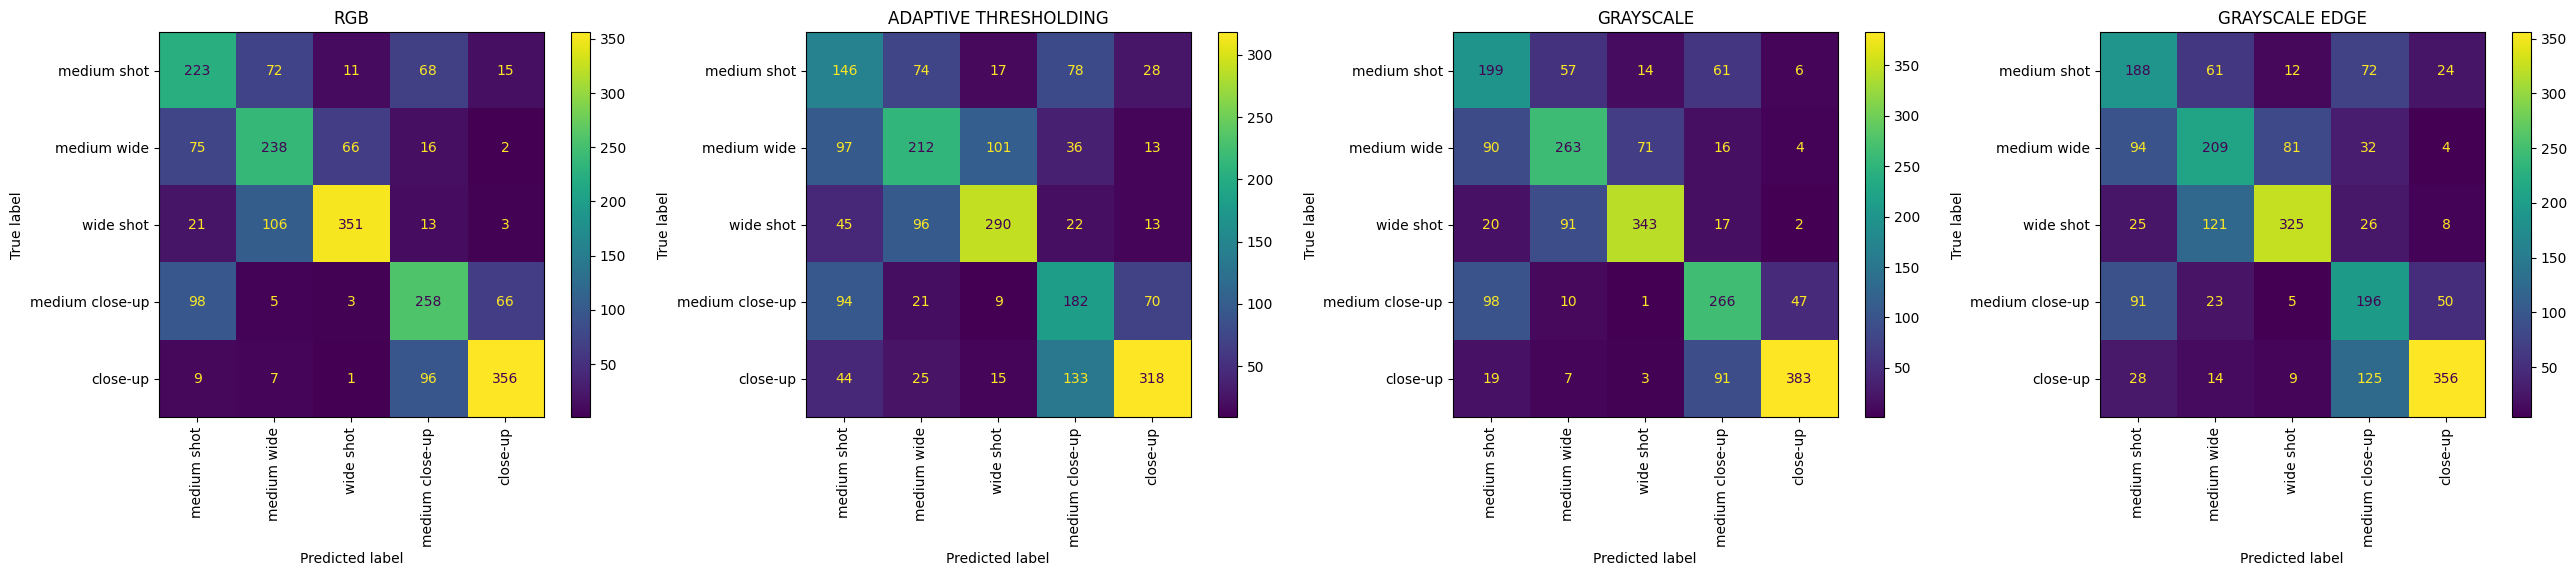

In [ ]:
num_models = len(list_of_models)
fig, axarr = plt.subplots(1, num_models, figsize=(32, 5))

labels = ['medium shot', 'medium wide', 'wide shot', 'medium close-up', 'close-up']

for i, couple in enumerate(list_of_models):
    name, model, test = couple[0], couple[1], couple[2]
    predictions = model.transform(test)
    metrics = MulticlassMetrics(predictions.select("label", "prediction").rdd.map(tuple))

    disp = ConfusionMatrixDisplay(
        confusion_matrix=metrics.confusionMatrix().toArray().astype(int),
        display_labels=labels
    )

    disp.plot(ax=axarr[i], xticks_rotation="vertical")
    axarr[i].set_title(name)

plt.show()

## **2.6** Test on new samples


### Function to return a new instance of the VGG16 model

In [ ]:
def model_definition():
  VGG_model = VGG16(weights='imagenet', include_top=False)

  for layer in VGG_model.layers: layer.trainable=False

  return VGG_model

### Function to extract the features of the new sample

In [ ]:
def get_sample_features(img, preprocess_function):
  model = model_definition()

  # apply preprocessing function to the image
  input = preprocess_function(img)

  input = np.expand_dims(input, axis=0)

  # extract the image features
  preds = model.predict(input, verbose=0)
  features = [x.flatten() for x in preds]

  return features

### Function to plot new samples with scores

In [ ]:
def plot_image_with_scores(img_path, label, df, sample_index):
    # Load the image
    image = Image.open(img_path).resize((320, 200))

    fig = plt.figure(figsize=(23, 5))

    # setting values to rows and column variables
    rows = 1
    columns = 2

    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, 1)

    # showing image
    plt.imshow(image)
    plt.axis('off')
    plt.title(str(sample_index) + ' ' + label)

    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)

    table = plt.table(cellText=df.values, colLabels=df.columns, loc='center', bbox=[0, 0, 1, 0.7])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)  # Adjust the values to center the table vertically
    plt.axis('off')

    plt.tight_layout()  # Ensures that the subplots and labels are properly centered
    plt.show()

### Function to perform predictions on new samples

In [ ]:
def softmax(z):
    assert len(z.shape) == 2

    s = np.max(z, axis=1)
    s = s[:, np.newaxis]
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis]
    return e_x / div


def prediction_sample(img_path, preprocessing_type):

  with open(img_path, 'rb') as file:
    img = file.read()

  # select the appropriate preprocessing mode and model
  match preprocessing_type:
    case "rgb":
      features = get_sample_features(img, preprocess_rgb)
      model = cvModel

    case "grayscale":
      features = get_sample_features(img, preprocess_grayscale)
      model = cvModel_grayscale

    case "adapt_thres":
      features = get_sample_features(img, adaptive_preprocessing)
      model = cvModel_adapt_thres

    case "grayscale_edge":
      features = get_sample_features(img, preprocess_grayscale_edge)
      model = cvModel_grayscale_edge

  # transform the features in the appropriate format
  features = features[0].tolist()

  data = [(features,)]

  schema = StructType([StructField("features", ArrayType(FloatType()))])

  # put the new features into a new spark df
  img_df = spark.createDataFrame(data=data, schema=schema)

  # transform the features in a vector
  img_df = img_df.withColumn("features", get_vectorized_features_udf("features"))

  # get the prediction
  prediction = model.transform(img_df)

  # transform the prediction in the appropriate format
  predictions = prediction.select('rawPrediction')

  raw_preds = [row[0] for row in predictions.collect()][0].values.tolist()

  # apply softmax function to get classes prediction percentages
  final_preds = softmax(np.array([raw_preds]))

  classes = ['medium shot', 'medium wide',  'wide shot', 'medium close-up', 'close-up']

  return [ '%.4f' % elem for elem in list(final_preds[0]) ]

### Plot new samples scores

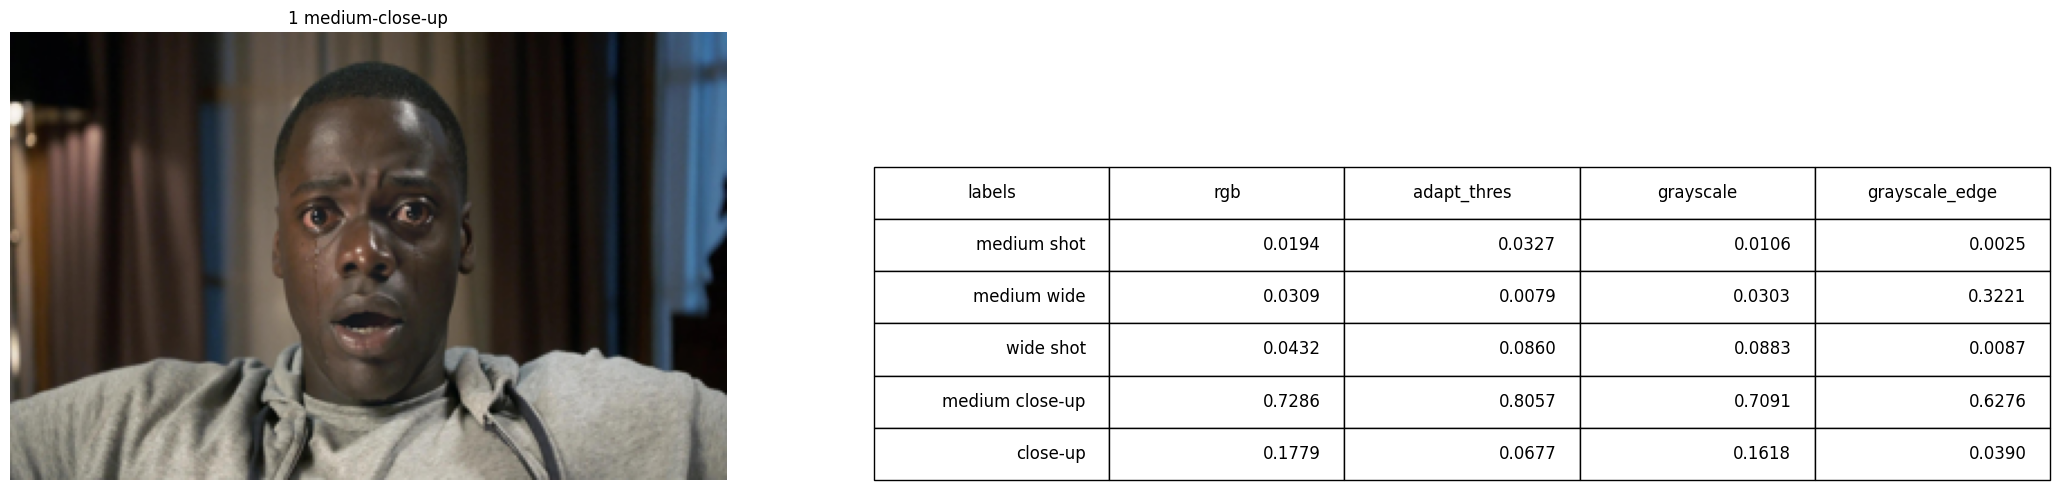

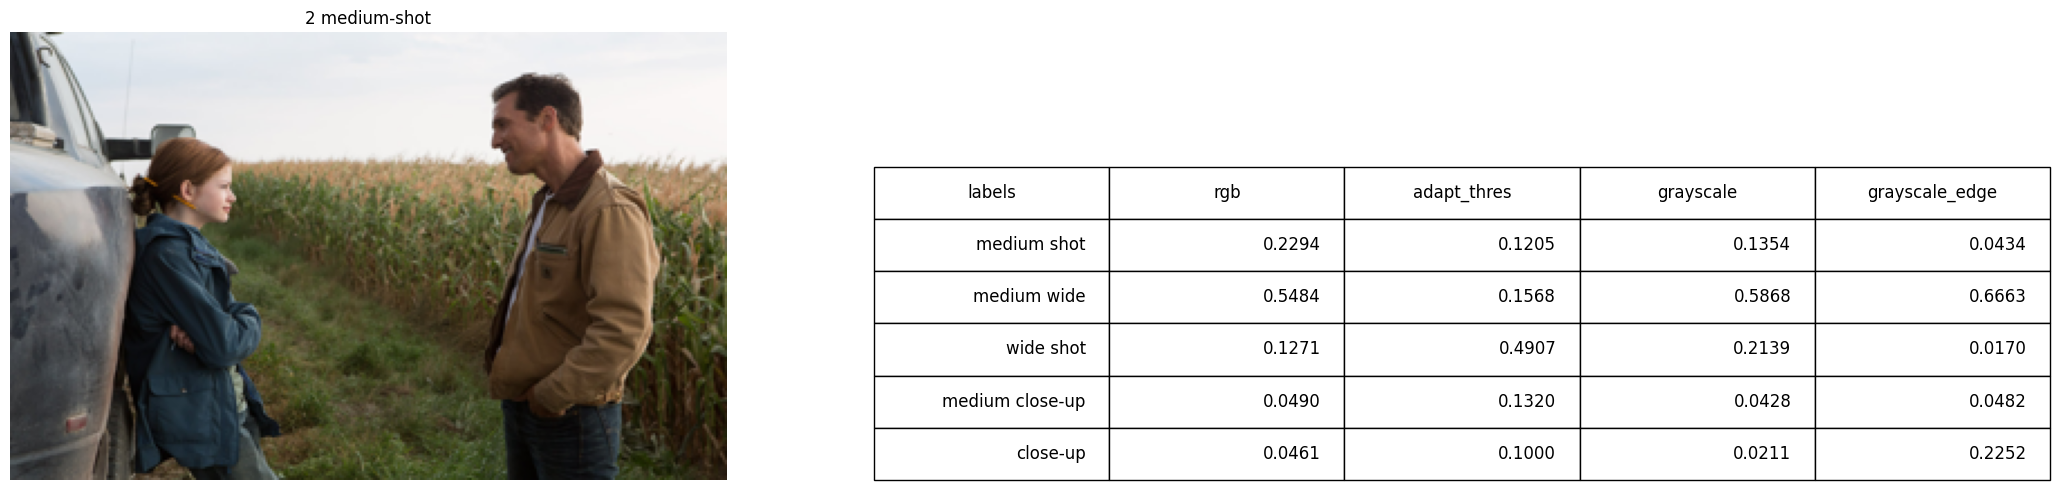

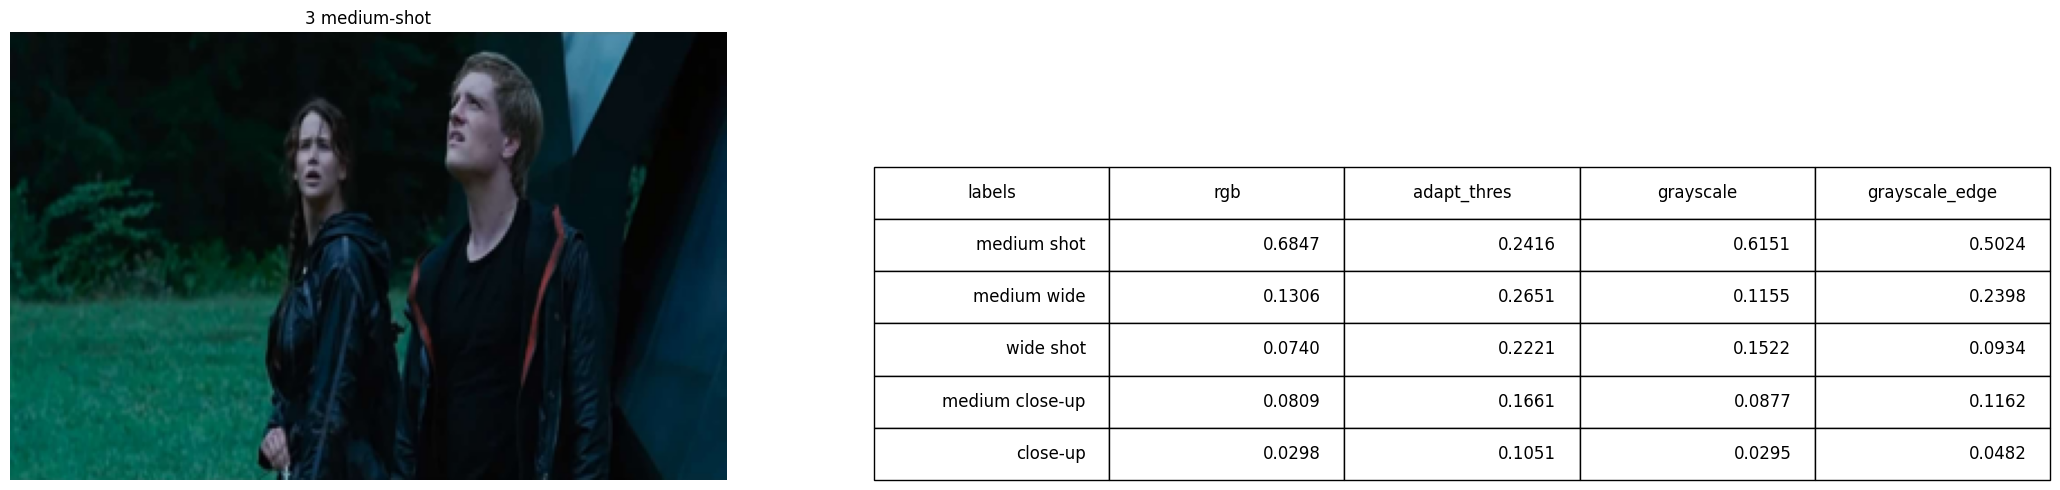

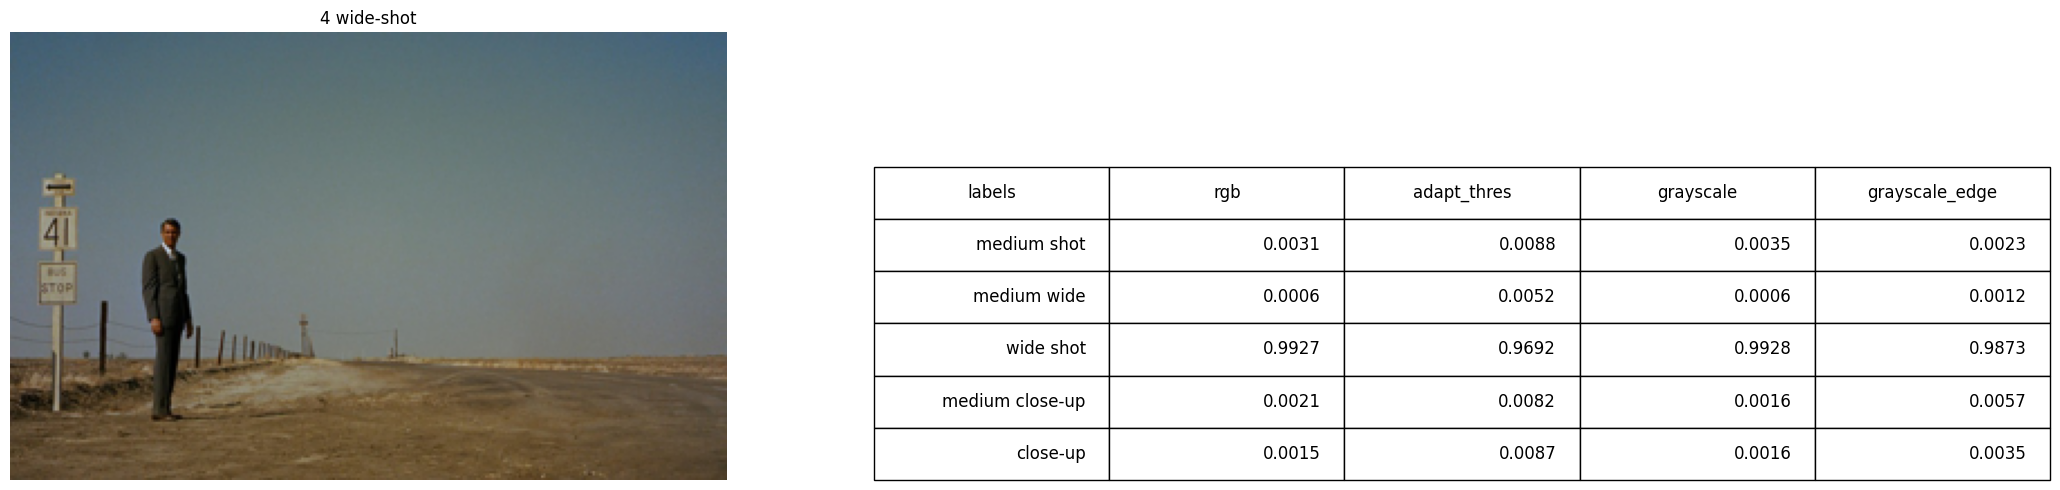

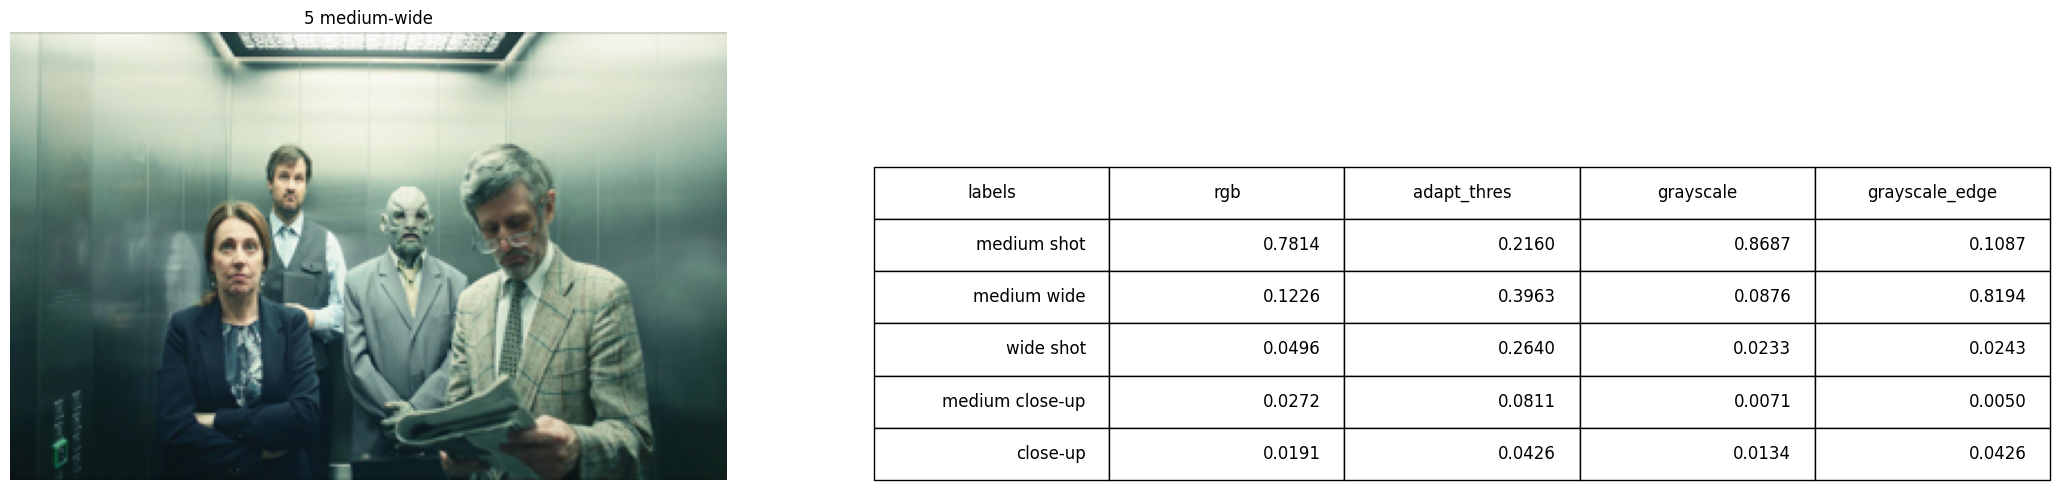

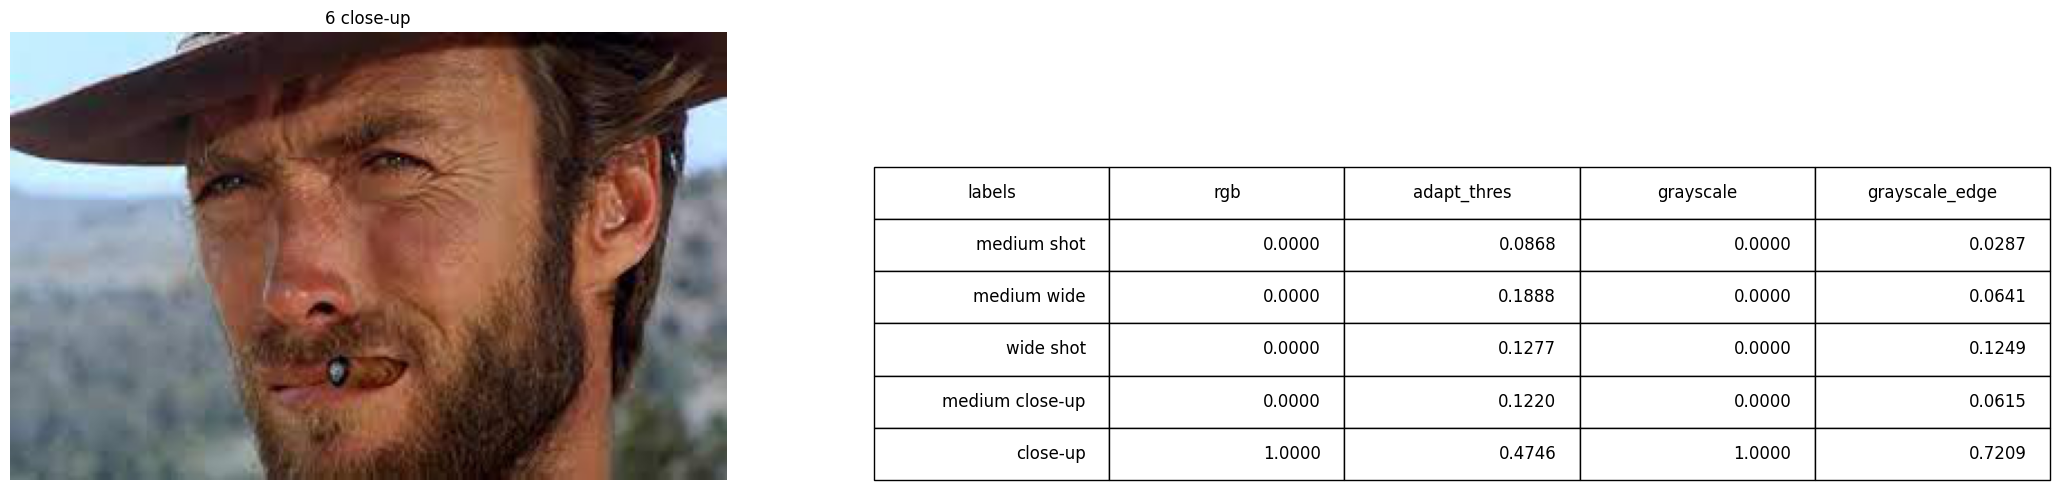

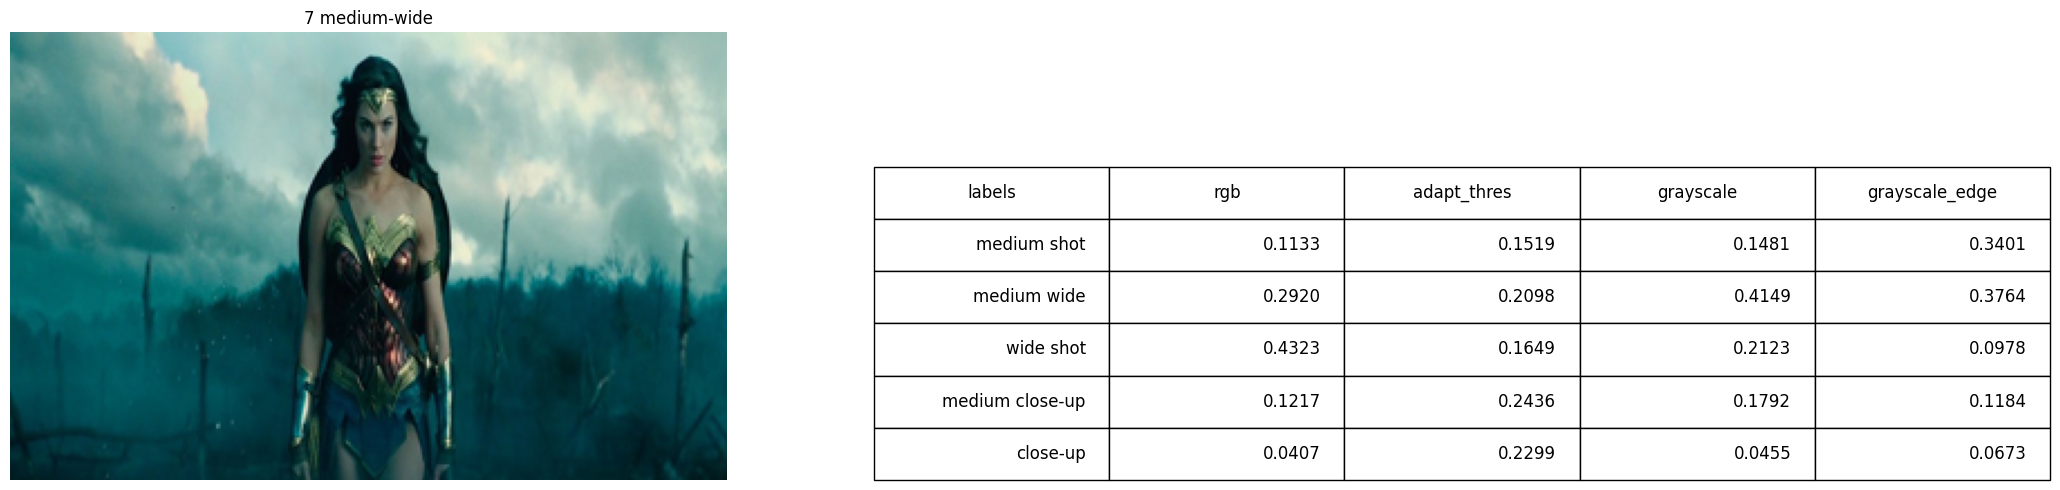

In [ ]:
directory = "/content/drive/My Drive/Big_Data/shot_type/shot_type_samples/"

i = 1
for sample_path in os.listdir(directory):
  label = sample_path.split('/')[-1].split('_')[0]
  result_df = pd.DataFrame([], columns=['labels', 'rgb', 'adapt_thres', 'grayscale', 'grayscale_edge'])

  result_df['labels'] = ['medium shot', 'medium wide',  'wide shot', 'medium close-up', 'close-up']
  result_df['rgb'] = prediction_sample(os.path.join(directory, sample_path), "rgb")
  result_df['adapt_thres'] = prediction_sample(os.path.join(directory, sample_path), "adapt_thres")
  result_df['grayscale'] = prediction_sample(os.path.join(directory, sample_path), "grayscale")
  result_df['grayscale_edge'] = prediction_sample(os.path.join(directory, sample_path), "grayscale_edge")
  plot_image_with_scores(os.path.join(directory, sample_path), label, result_df, i)
  i += 1

## **2.7** Conclusion

### The best results are related to models trained on preprocessed grayscale and rgb data. These models respectively offer an accuracy of 0.66 and 0.65 which is not a bad result considering the data used. These models have quite similar Recall and F1 score values, respectively 0.59, 0.57, for the rgb model, and 0.61, 0, 60 for the grayscale one. The most substantial difference between the two lies in the value of Precision, where the grayscale-based model scores about 5% better than the RGB-based model. Observing the confusion matrix produced, we can see that the majority of errors found concern the medium shot and medium wide classes. In general, the entire dataset has a very high intra-class variability which already makes the classification task complex in itself. In particular, the two classes medium shot and medium wide contain images that can be considered to belong to both. This is due to the fact that, from a cinematographic point of view, the distinctions made on the types of shots often do not involve these two classes, but rather other methods of classification, such as a medium shot or full length. We find confirmation of what has been said by observing the scores obtained on the new samples, where in the case of sample number 4 we can see how the models with the lowest accuracy carry out a correct classification of the sample unlike the two best models. In conclusion, considering the proposed approach and the related preprocessing techniques we expect to be able to obtain even better results by exploiting a dataset that has a greater distinction between the classes.

## **2.8** Approches Comparison

### Considering the two approaches proposed, it is easy to see how the one that exploits the featurization of the images through the VGG16 and the classification through the SVM algorithm, obtains decidedly superior results compared to the one that exploits the transfer learning technique with the VGG16 network. In fact, the best accuracy of the approach based on transfer learning is 0.52, while the best of the model based on SVM is 0.66. Observing the confusion matrix of the models, although not easily comparable given the order of the labels and the different number of elements in the different test sets, we can see how both models obtain the best results in the classification of 'close-up' images, and the worst results in 'medium shot' image classification. In the case of the grayscale model, however, we notice a higher score in the classification of the 'wide shot' images, a score that is not far from that obtained by the 'close-up' label. In conclusion, we can state that for the shot type classification task, the approach that has shown the best results is the one proposed in this notebook, which could provide even better results by exploiting preprocessing techniques aimed at extracting the most relevant features for recognize different shot types.
![picture](https://drive.google.com/uc?id=1fogWEWTosFlllEvr3_mY_N49f-_MBaHq)